### Table of Contents
- Intro
- Nowcast
- Using Nowcast to improve Forecast



## Introduction


Forecasting in the presence of reporting delay: simulation study. Given some delayed data, can we use the method described in Gibson, Reich, Ray to improve forecasts based on predicted values of nowcasting. 

Strategy


- Generate data for t=0..100
- Delay data from t=90..100 according to fixed delay proportions (that is artificially scale down the data)
- Fit delay model to simulated delayed data
- Generate nowcasts for t0=90..100
- Retrain process model on mean predicted nowcasts (t=90..100)
- Forecast t=100-110 using updated process model and original process model 
- Compare MSE

### Notation 

We define $y_t$ as an observed value of this incidence in time interval $t$ from our time series $\{y_1, y_2, y_3, \dots\, y_t, \dots, y_T\}$.
We assume that these observations are draws from random variables $Y_1, Y_2, Y_3, \dots, Y_t, \dots, Y_T$, whose probability distributions can be thought of as a function of $t$, prior values of $y$ represented as $y_{1:t}$, and other covariates $x_t$.
We use $T$ throughout to refer to the total number of time points in the time-series and $t$ to refer to a specific time point relative to which a forecast is generated.


For forecasts of the time-series values itself, \ie when a target is defined to be a past or future value of the time-series $Y_{t+k}$, we use a special nomenclature, referring to them as `k-step-ahead` forecasts.  
We define $Z_{i|t}$ as a random variable for target $i$ positioned relative to time $t$. For example, in the infectious disease context, $Z_{i|t}$ could be:

 - incidence at time $t$, or $Y_t$,
 - incidence at time $t+k$ either in the future or past relative to time $t$, or $Y_{t+k}$, where $k$ is a positive or negative integer,
 - peak incidence within some period of time or season, or $\max_t (Y_t)$ where $t$ are defined to be within a season,
    \item the time at which a peak occurs within some season, or $\{ t': Y_{t'} = \max_t (Y_t) \} $
 - a binary indicator of whether incidence at time $t+k$ is above a specified threshold $C$, or $\mathds{1} \{Y_{t+k}>C\}$.
\end{itemize}


A forecast must provide {\em quantitative and probabilistic} information about an outcome.
In the context of this notation, a forecast can be represented as a predictive density function for a target, or $f_{z_{i|t}}(z|y_{1:t}, t, x_{t})$.
The form of this density function will depend on the type of variable that $Z$ is, and it could be derived from a known parametric distribution or specified directly.

In our initial experiments we are mostly concerned with the following distribution

$$f_{Y_{t+k}|i}(Y_t | y_{1:t},t,x_t)$$

that is, $k-step$ ahead forecast relative to time $t$.


To enable clear definitions for forecasting in real-time, forecasts must be associated with a specific time $t$.
In our database infrastructure, we refer to this time as a {\tt timezero}.
This specific time $t$ represents the point relative to which targets are defined.
For example, if a forecast is associated with week 45 in 2013, then a `1-step-ahead' forecast would be associated with incidence in week 46 of 2013 and a `3-step-ahead' forecast would be associated with week 48.
This {\tt timezero} is not an intrinsic feature of a project or dataset, and is more or less arbitrarily defined or named by the data analyst or project organizers.
For example, in the project above, if we defined a timezero as week 44 in 2013 then a `2-step-ahead' forecast would be associated with incidence in week 46, same as a `1-week-ahead' forecast from week 45.

However, a second important date further refines our notion of what constitutes a forecast. 
We define a date $d$ as a {\tt data-version-date}. 
Taken together, a $(t,d)$ pair uniquely define a forecast setting.
Specifically, a forecast for $(t,d)$ represents forecasts for targets relative to date $t$ using data available at date $d$. 

## Simulation Study, fixing delay proportions and generating nowcast

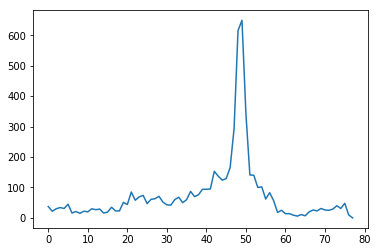

In [2]:
import numpy as np
import matplotlib.pyplot as plt


n_t_d = []
with open("province-biweek_with_delays.csv") as f:
    i = 0
    for line in f.readlines():
        if i > 0:
            n_t_d.append(line.replace("\n","").split(','))
        i+=1

n_t_d_1 = []

for elm in n_t_d:
    if elm[2] == "11":
        n_t_d_1.append(elm)


index_to_dates = {}
dates_to_index = {}
count = 0
for i in ["2014","2015","2016"]:
    for j in range(1,27):
        index_to_dates[count] = str(i)+str(j)
        dates_to_index[str(i)+str(j)] = count
        count +=1
        
reporting_matrix = np.zeros((26*3,26*3))

for elm in n_t_d_1:
    try:
        sick_date = elm[0]+elm[1]
        report_date = elm[-2] + elm[-1]
        cases = elm[3]
        reporting_matrix_row = dates_to_index[sick_date] 
        reporting_matrix_col =  dates_to_index[report_date] 
        reporting_matrix[reporting_matrix_row,reporting_matrix_col] = int(cases)
    except:
        pass
#np.set_printoptions(threshold=np.nan)

plt.plot(reporting_matrix.sum(axis=1))
plt.show()

78
0.042977530803083634


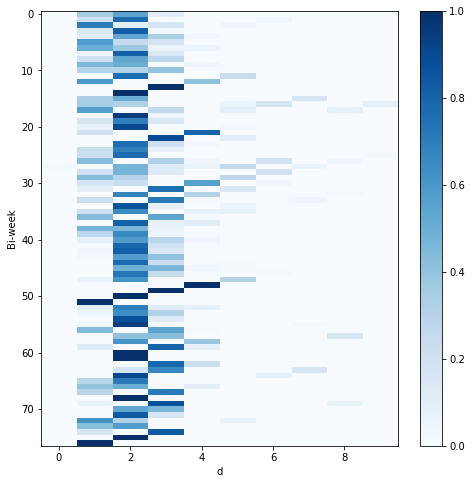

In [3]:
print (len(reporting_matrix))
D=10
n_t_d = np.zeros((len(reporting_matrix),D))

for i in range(len(reporting_matrix)):
    for j in range(i,i+D):
        try:
            n_t_d[i,j-i] = reporting_matrix[i][j]
        except:
            pass
n_t_d = n_t_d[:-1]
p_hat = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat.append(n_t_d[i]/np.sum(n_t_d[i]))
    
p_hat = np.array(p_hat)
print (np.var(p_hat[:2]))
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

In [214]:
# list for holding simulated data, length 260
arr_list = np.zeros(260)
# iterate over season  
for s in range(10):
    #iterate over biweek per season
    for t in range(26):
        season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
        e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
        arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 

# plot simulated data to make sure it looks like ID        
ts = arr_list[:100]

p_vec = np.random.dirichlet(np.append([50,100,200,100,100],np.ones(D-5)),size=1)[0]


sim_n_t_d = []
for i in range(78):
    tmp1 = np.random.multinomial(ts[i],p_vec,size=D).tolist()[0]
    sim_n_t_d.append(tmp1 )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)    
    
p_hat_sim = []
from matplotlib.pyplot import cm

for i in range(len(n_t_d)):
    p_hat_sim.append(sim_n_t_d[i]/np.sum(sim_n_t_d[i]))
    
    
plt.figure(figsize=(8,8))
plt.ylabel("Bi-week")
plt.xlabel("d")
plt.imshow(p_hat_sim,aspect='auto',cmap=cm.Blues)
plt.legend()
plt.colorbar()
plt.show()

plt.plot(sim_n_t_d.sum(axis=1))
plt.show()

NameError: name 'plt' is not defined

In order to simulate delayed data we first randomly simualte the delay proportions from a dirichlet distribution

If the true delay distribution is given by 
$$p_0,...,p_{9} \sim Dirichlet(\alpha_1,...,\alpha_{10})$$

we can interpret $p_i$ as the percentage of cases that were delayed by $i$ days.

In [9]:
import numpy as np
season_data = []
arr_list = np.zeros(260)
for s in range(10):
        #iterate over biweek per season
        for t in range(26):
            season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[(s-1)*26+t] = np.random.poisson(10*e_y) 
            season_data.append(arr_list[(s-1)*26+t])
    # plot simulated data to make sure it looks like ID        
ts = arr_list
from pyramid.arima import auto_arima
stepwise_model = auto_arima(ts, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True)
future_forecast = stepwise_model.predict(n_periods=26)
print (future_forecast)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2183.756, BIC=2201.560, Fit time=1.743 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=2194.376, BIC=2208.619, Fit time=0.747 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=2250.220, BIC=2264.463, Fit time=0.555 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=2154.851, BIC=2176.215, Fit time=3.541 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=2201.088, BIC=2218.892, Fit time=1.323 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2140.835, BIC=2165.760, Fit time=4.453 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12); AIC=2135.626, BIC=2156.990, Fit time=4.458 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 2, 12); AIC=2146.540, BIC=2164.344, Fit time=3.802 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_orde

In [301]:
import emcee
from scipy.stats import binom
from scipy.stats import norm
import pymc3 as pm

def bayes_estimate(p_vec,process,process_var,partially_observed,scale_factor):
    basic_model = pm.Model()

    with basic_model:

        # Priors for unknown model parameters
        n_t_inf = pm.Normal('n_t_inf', mu=process, sd=np.sqrt(process_var)/scale_factor)


        # Likelihood (sampling distribution) of observations
        Y_obs = pm.Binomial('Y_obs', n=n_t_inf, p=sum(p_vec), observed=sum(partially_observed))
    map_estimate = pm.find_MAP(model=basic_model)
    return map_estimate['n_t_inf']

260


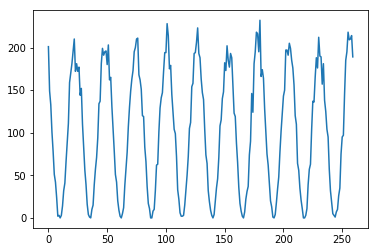

Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


logp = -inf, ||grad|| = 0.66147: 100%|██████████| 5/5 [00:00<00:00, 1211.88it/s]
logp = -441.27, ||grad|| = 4.7609: 100%|██████████| 10/10 [00:00<00:00, 1841.30it/s]
logp = -224.96, ||grad|| = 4.0772: 100%|██████████| 11/11 [00:00<00:00, 1256.26it/s]
logp = -75.104, ||grad|| = 2.8341: 100%|██████████| 10/10 [00:00<00:00, 1227.73it/s]
logp = -67.117, ||grad|| = 2.6323: 100%|██████████| 10/10 [00:00<00:00, 1684.39it/s]
logp = -32.896, ||grad|| = 2.033: 100%|██████████| 9/9 [00:00<00:00, 1464.15it/s]
logp = -22.994, ||grad|| = 0.63668: 100%|██████████| 11/11 [00:00<00:00, 1035.10it/s]
logp = -13.035, ||grad|| = 0.24292: 100%|██████████| 9/9 [00:00<00:00, 1145.05it/s]
logp = -11.322, ||grad|| = 0.092297: 100%|██████████| 9/9 [00:00<00:00, 869.23it/s]
logp = -9.9417, ||grad|| = 0.035224: 100%|██████████| 9/9 [00:00<00:00, 2144.94it/s]


model 2
[216.82 -72.85 131.51 171.2  183.53 204.72 203.91 218.01 205.4  185.93]
model 1
[ 95.    97.44 144.78 185.74 195.11 216.63 204.17 217.88 201.34 156.41]
truth
[ 95.  97. 145. 185. 195. 218. 209. 210. 214. 189.]
process model
[195.81869823396534, 202.9755913778868, 210.48745327820774, 218.37188973335017, 226.64737975700507, 235.33331888800595, 244.45006464829285, 254.0189842555077, 264.0625047020469, 274.60416531794283]
------
428.1593666666667
49.181666666666565
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


logp = -inf, ||grad|| = 0.66147: 100%|██████████| 5/5 [00:00<00:00, 1318.63it/s]
logp = -447.37, ||grad|| = 4.8186: 100%|██████████| 10/10 [00:00<00:00, 2150.59it/s]
logp = -227.47, ||grad|| = 4.1154: 100%|██████████| 11/11 [00:00<00:00, 2243.05it/s]
logp = -75.425, ||grad|| = 2.844: 100%|██████████| 10/10 [00:00<00:00, 973.04it/s]
logp = -66.967, ||grad|| = 2.6275: 100%|██████████| 10/10 [00:00<00:00, 2219.33it/s]
logp = -32.807, ||grad|| = 2.0283: 100%|██████████| 9/9 [00:00<00:00, 1534.25it/s]
logp = -22.745, ||grad|| = 0.63049: 100%|██████████| 11/11 [00:00<00:00, 2318.23it/s]
logp = -13.006, ||grad|| = 0.24211: 100%|██████████| 9/9 [00:00<00:00, 1623.95it/s]
logp = -11.287, ||grad|| = 0.091738: 100%|██████████| 9/9 [00:00<00:00, 1981.14it/s]
logp = -9.7413, ||grad|| = 0.033506: 100%|██████████| 9/9 [00:00<00:00, 1668.82it/s]


model 2
[216.82 -76.19 131.46 171.03 183.61 204.79 204.15 218.1  205.67 189.29]
model 1
[ 95.    97.41 144.75 185.72 195.12 216.64 204.41 217.97 201.62 159.72]
truth
[ 95.  97. 145. 185. 195. 218. 209. 210. 214. 189.]
process model
[195.81869823396534, 202.9755913778868, 210.48745327820774, 218.37188973335017, 226.64737975700507, 235.33331888800595, 244.45006464829285, 254.0189842555077, 264.0625047020469, 274.60416531794283]
------
358.03456666666665
45.027666666666704
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


logp = -inf, ||grad|| = 0.66147: 100%|██████████| 5/5 [00:00<00:00, 1385.81it/s]
logp = -445.22, ||grad|| = 4.7983: 100%|██████████| 10/10 [00:00<00:00, 1733.97it/s]
logp = -225.83, ||grad|| = 4.0904: 100%|██████████| 11/11 [00:00<00:00, 2657.07it/s]
logp = -75.941, ||grad|| = 2.8598: 100%|██████████| 10/10 [00:00<00:00, 1633.42it/s]
logp = -68.073, ||grad|| = 2.6625: 100%|██████████| 10/10 [00:00<00:00, 2120.48it/s]
logp = -33.179, ||grad|| = 2.0481: 100%|██████████| 9/9 [00:00<00:00, 1898.73it/s]
logp = -23.133, ||grad|| = 0.64012: 100%|██████████| 11/11 [00:00<00:00, 1956.55it/s]
logp = -13.225, ||grad|| = 0.24815: 100%|██████████| 9/9 [00:00<00:00, 1520.84it/s]
logp = -11.338, ||grad|| = 0.092546: 100%|██████████| 9/9 [00:00<00:00, 1835.58it/s]
logp = -9.8171, ||grad|| = 0.034161: 100%|██████████| 9/9 [00:00<00:00, 1713.98it/s]


model 2
[216.82 -75.02 131.5  170.77 183.04 204.49 203.78 217.42 205.28 188.  ]
model 1
[ 95.    97.42 144.77 185.69 195.05 216.59 204.04 217.28 201.22 158.44]
truth
[ 95.  97. 145. 185. 195. 218. 209. 210. 214. 189.]
process model
[195.81869823396534, 202.9755913778868, 210.48745327820774, 218.37188973335017, 226.64737975700507, 235.33331888800595, 244.45006464829285, 254.0189842555077, 264.0625047020469, 274.60416531794283]
------
383.4134666666667
44.03159999999993
Starting forward filtering...
Forward fitering completed.
Starting backward smoothing...
Backward smoothing completed.


logp = -inf, ||grad|| = 0.66147: 100%|██████████| 5/5 [00:00<00:00, 1231.52it/s]
logp = -438.89, ||grad|| = 4.7383: 100%|██████████| 10/10 [00:00<00:00, 2334.32it/s]
INFO (theano.gof.compilelock): Refreshing lock /Users/gcgibson/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock
INFO:theano.gof.compilelock:Refreshing lock /Users/gcgibson/.theano/compiledir_Darwin-16.7.0-x86_64-i386-64bit-i386-2.7.13-64/lock_dir/lock


AssertionError: ('The following error happened while compiling the node', Elemwise{Composite{((i0 * (i1 + i2)) + Switch(Composite{Identity(LE(i0, i1))}(i3, i2), psi((i4 + i2)), i5) + Switch(Composite{Identity(LE(i0, i1))}(i3, i2), (-psi((i6 + i2))), i5) + Switch(Composite{Identity(LE(i0, i1))}(i3, i2), i7, i5))}}(TensorConstant{-0.0001625..9277172432}, TensorConstant{-210.48745327820774}, n_t_inf, TensorConstant{144}, TensorConstant{1.0}, TensorConstant{0}, TensorConstant{-143.0}, TensorConstant{-5.197046836141741}), '\n')

In [303]:
from scipy.special import expit
import matplotlib.pyplot as plt
np.random.seed(1)

variance_level_results = []
import sys
from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
from sklearn.metrics import mean_squared_error

D = 10
arr_list = np.zeros(260)
        # iterate over season  
for s in range(10):
        #iterate over biweek per season
        for t in range(26):
            season_effect = np.random.choice([10,10,10], p = [0.2, 0.6, 0.2])
            e_y = season_effect*np.cos(10*(t+np.pi)/(13*np.pi)) + season_effect
            arr_list[(s-1)*26+t] = np.random.poisson(10*e_y)
    # plot simulated data to make sure it looks like ID        
ts =arr_list#[16:len(arr_list)-10]
print (len(ts))
plt.plot(ts)
plt.show()

p_vec = np.random.dirichlet(np.append([50,100,200,100,100],np.ones(D-5)),size=1)[0]


sim_n_t_d = []
for i in range(len(ts)):
    tmp1 = np.random.multinomial(ts[i],p_vec,size=D).tolist()[0]
    sim_n_t_d.append(tmp1 )
sim_n_t_d = np.array(sim_n_t_d,dtype=np.float32)


sim_n_t_d = sim_n_t_d.reshape((-1,26,D))

rmse_vec = []
#iterate over all 10 seasons doing a leave one season out
for var in np.arange(10):
    season_for_leave_out = var
    train = [sim_n_t_d[x] for x in range(10) if x not in [season_for_leave_out]]
    test = sim_n_t_d[season_for_leave_out]
    
    
    train = np.array(train)
    train_n_t_d = train.reshape((-1,D))
    ts = train_n_t_d.sum(axis=1)
    data_to_be_scaled_down  = train_n_t_d[len(ts)-D:]


    
    
    delayed_data = []
    count = D
    for i in range(len(data_to_be_scaled_down)):
        tmp = data_to_be_scaled_down[i][:count].tolist()
        while len(tmp) <10:
            tmp.append(0)
        delayed_data.append(tmp)
        count -=1 
    
    
    training_data = np.append(train_n_t_d[:len(ts)-D],delayed_data,axis=0)

    k = np.array(train_n_t_d).shape[1 ]
    p_vec_noise = np.ones(k)

    for i in range(len(ts)-D):
        p_vec_noise += train_n_t_d[i]

    p_vec_noise = p_vec_noise/np.sum(p_vec_noise)
    #### training data is all set
    
    ###filling in ps model 1
    model_1_delay = []
    count = D
    for i in range(len(delayed_data)):
        delay_forecast = np.sum(delayed_data[i])/np.sum(p_vec_noise[:count])
        model_1_delay.append(np.round(delay_forecast,2))
        count -= 1
    model_1_delay = np.array(model_1_delay)
    
    
    
    #### filling in ps model 2
    
    from pydlm import dlm, trend, seasonality, dynamic, autoReg, longSeason
    myDLM = dlm(ts[len(ts)-D:])
    myDLM = myDLM + seasonality(26, name='7day', w=1.0)
    myDLM = myDLM + autoReg(degree=1, data=ts[len(ts)-D:], name='ar2', w=1.0)
    myDLM.fit()
    (process_model_forecast, predictVar) = myDLM.predictN(N=D, date=myDLM.n-1)
    model_2_delay = []
    count = D
    
    for i in range(len(data_to_be_delayed)):
        tmp = bayes_estimate(p_vec_noise[:count],process_model_forecast[i],predictVar[i],delayed_data[i],.5)
        model_2_delay.append(np.round(tmp,2))
        count -= 1
    model_2_delay = np.array(model_2_delay)
   
    print ("model 2")
    print (model_2_delay)
    print ("model 1")
    print (model_1_delay)
    print ("truth")
    print (ts[len(ts)-D:])
    print ("process model")
    print (process_model_forecast)
    ###filling in ps
    print ("------")
    cut_blah = 7
    print (mean_squared_error(model_1_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    print (mean_squared_error(model_2_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    rmse_vec.append(mean_squared_error(model_2_delay[cut_blah:],ts[len(ts)-D+cut_blah:])/mean_squared_error(model_1_delay[cut_blah:],ts[len(ts)-D+cut_blah:]))
    
    
        
        
        

In [293]:
print (np.mean(rmse_vec))


0.93356434600064
